### OurOwnGan Implementation ###

Resouce:

Pytorch tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt
import argparse
import random
from __future__ import print_function
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Set up input ###

In [3]:
workers = 2
batch_size = 16
image_size = 256
nc = 3
nz = 100
ngf = 128
ndf = 128
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu =  1

### Load In Data ###

In [4]:
valid_size = .2
num_workers = 2
classes = ["Real", "Fake"]

train_transform = transforms.Compose([transforms.RandomResizedCrop(image_size),
                                transforms.ToTensor()])

test_transform = transforms.Compose([transforms.RandomResizedCrop(image_size),
                                transforms.ToTensor()])

categories = os.listdir("./progan_train")
train_datasets = []
print("Loading Training Data...", flush=True)
#for category in tqdm(categories):
#    train_datasets.append(datasets.ImageFolder("./progan_train/" + category, transform=train_transform))
train_datasets.append(datasets.ImageFolder("./progan_train/airplane/", transform=train_transform))

train_dataset = torch.utils.data.ConcatDataset(train_datasets)


#train_dataset = datasets.ImageFolder("./progan_train/horse/", transform=train_transform)

print("Loading Testing Data...", flush=True)
test_datasets = []
#for category in tqdm(categories):
#    test_datasets.append(datasets.ImageFolder("./CNN_synth_testset/progan/" + category, transform=test_transform))

test_datasets.append(datasets.ImageFolder("./CNN_synth_testset/progan/airplane/", transform=test_transform))

test_dataset = torch.utils.data.ConcatDataset(test_datasets)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

class_names = train_datasets[0].classes

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Loading Training Data...
Loading Testing Data...


In [5]:
print(len(train_loader), len(valid_loader), len(test_loader))

1801 451 25


In [6]:
torch.save(train_loader, "./ourOwnGan/train_loader.pt")
torch.save(valid_loader, "./ourOwnGan/valid_loader.pt")
torch.save(test_loader, "./ourOwnGan/test_loader.pt")

In [7]:
train_loader = torch.load("./ourOwnGan/train_loader.pt")
valid_loader = torch.load("./ourOwnGan/valid_loader.pt")
test_loader = torch.load("./ourOwnGan/test_loader.pt")
len(train_loader), len(valid_loader), len(test_loader)

(1801, 451, 25)

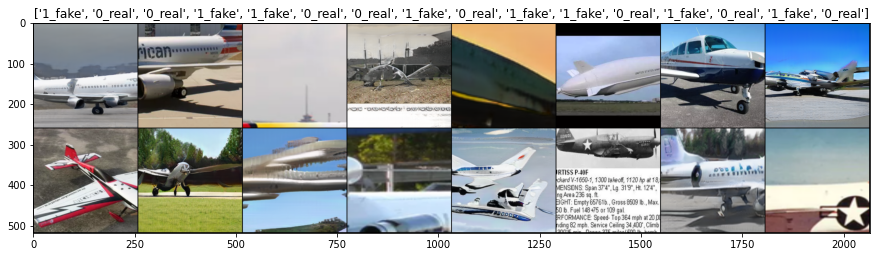

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


plt.figure(figsize=(15,15))
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Discriminator ###

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # dimension change 
            #################################
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            ####################################
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            #####################################
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            ####################################
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            ########################################
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            ###################################################
            nn.Conv2d(ndf * 32, ndf * 32, 4, stride=1, padding=0, bias=False),
            ############
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(4096, 2048),
            nn.Linear(2048, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
            nn.Linear(64,32),
            nn.Linear(32, 16),
            nn.Linear(16,2)
            
        )

    def forward(self, input):
        return self.main(input)

### Train ###

In [ ]:
model = Discriminator()
model = model.to(device)

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
num_epochs = 5
since = time.time()
print_every_n_batches = 300
losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    #running_corrects = 0
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = torch.squeeze(outputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % print_every_n_batches == print_every_n_batches - 1:
             #Calculate validation loss
            n = 0
            acc = torch.tensor(0).to(device)
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                y_pred = torch.argmax(model(inputs), 1) 
                y_pred = torch.squeeze(y_pred)
                acc = torch.add(acc, torch.sum(y_pred == labels))
                n += len(labels)

            val_acc = acc / float(n)
            print('[%d, %5d] training loss: %.3f val acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every_n_batches, val_acc), end = " ")
            val_accs.append(val_acc)
            losses.append(running_loss / print_every_n_batches)
            running_loss = 0.0
            
    
            time_elapsed = time.time() - since
            print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    torch.save(model, "./ourOwnGan/model" + str(epoch) + ".pt")
        
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

In [ ]:
torch.save(model, "./ourOwnGan/netD.pt")

In [ ]:
n = 0
acc = torch.tensor(0).to(device)
for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    y_pred = torch.argmax(model.forward(inputs), 1) 
    y_pred = torch.squeeze(y_pred)
    acc = torch.add(acc, torch.sum(y_pred == labels))
    n += len(labels)
    
acc / float(n)

In [ ]:
gans = os.listdir("./CNN_synth_testset")
test_accs = []
gans.remove("progan")
for gan in tqdm(gans):
    subdirs = os.listdir("./CNN_synth_testset/" + gan)
    if len(subdirs) == 2:
        gan_dataset = datasets.ImageFolder("./CNN_synth_testset/" + gan, transform=test_transform)
    else:
        gan_datasets = [datasets.ImageFolder("./CNN_synth_testset/" + gan + "/" + cat, transform=test_transform) for cat in subdirs]
        gan_dataset = torch.utils.data.ConcatDataset(gan_datasets)
        
    gan_loader = torch.utils.data.DataLoader(gan_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
    n = 0
    acc = torch.tensor(0).to(device)
    for data in gan_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = torch.argmax(model.forward(inputs), 1) 
        acc = torch.add(acc, torch.sum(y_pred == labels))
        n += len(labels)
    
    test_accs.append(acc / float(n))

In [ ]:
plt.figure(figsize=(20,5))
plt.title("Test Accuracies")
plt.bar(gans, test_accs)

In [ ]:
import pickle
with open("./ourOwnGan/test_accs.txt", "wb") as file:
    pickle.dump(test_accs, file)